In [1]:
#INSTAL LIBRARY PYSPARK

!pip install pyspark py4j


In [2]:
#MEMBUAT SPARK SESSION

from pyspark.sql import SparkSession
import findspark
findspark.init()
from pyspark import SparkFiles
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

spark = SparkSession.builder.appName("mypyspark").getOrCreate()
spark

In [3]:
#MEMBACA DATA Automobile_data.csv 

data = spark.read.csv("AHH.csv", header=True, inferSchema=True)


In [4]:
columns_to_drop = [ '_c3', '_c4', '_c5','_c6','_c7']
data = data.drop(*columns_to_drop)

In [5]:
data.show(5)
data.printSchema()
data.describe().show()

+------------+---------+---------+
|      Daerah|Laki-laki|Perempuan|
+------------+---------+---------+
|        ACEH|    68.26|    72.16|
|    SIMEULUE|    63.52|    67.36|
|    Simeulue|    63.52|    67.36|
|ACEH SINGKIL|    65.56|    69.54|
|Aceh Singkil|    65.56|    69.54|
+------------+---------+---------+
only showing top 5 rows

root
 |-- Daerah: string (nullable = true)
 |-- Laki-laki: double (nullable = true)
 |-- Perempuan: double (nullable = true)

+-------+------+------------------+------------------+
|summary|Daerah|         Laki-laki|         Perempuan|
+-------+------+------------------+------------------+
|  count|  1067|              1067|              1067|
|   mean|  NULL| 67.95431115276463| 71.86049671977506|
| stddev|  NULL|3.4174378683662683|3.3645240076519234|
|    min|  ACEH|             53.86|             57.36|
|    max|Yalimo|             76.09|             79.83|
+-------+------+------------------+------------------+



In [6]:
data = data.na.drop()

In [7]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(
    inputCols = ['Laki-laki','Perempuan'],
    outputCol = "features")

In [8]:
data = assembler.transform(data)

In [9]:
data.select('features').show(5)

+-------------+
|     features|
+-------------+
|[68.26,72.16]|
|[63.52,67.36]|
|[63.52,67.36]|
|[65.56,69.54]|
|[65.56,69.54]|
+-------------+
only showing top 5 rows



In [10]:
from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol="features", outputCol="scaledFeat", withStd=True, withMean=False)
scaler_model = scaler.fit(data)
data = scaler_model.transform(data)


In [20]:
data.printSchema()

root
 |-- Daerah: string (nullable = true)
 |-- Laki-laki: double (nullable = true)
 |-- Perempuan: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- scaledFeat: vector (nullable = true)



In [26]:
from pyspark.ml.clustering import KMeans
kmeans = KMeans(featuresCol='scaledFeat',k=2)

In [27]:
model = kmeans.fit(data)

In [28]:
results = model.transform(data)

In [29]:
center = model.clusterCenters()

In [30]:
print(center)

[array([18.97330371, 20.45697604]), array([20.58046086, 22.04657516])]


In [31]:
results.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|         1|  605|
|         0|  462|
+----------+-----+



In [32]:
results_pd = results.toPandas()

In [33]:
# MENAMPILKAN DATA SETELAH DI CONVERT KE PANDAS

results_pd

,Daerah,Laki-laki,Perempuan,features,scaledFeat,prediction
0,ACEH,68.26,72.16,"[68.26, 72.16]","[19.974028096268565, 21.447313152138843]",1
1,SIMEULUE,63.52,67.36,"[63.52, 67.36]","[18.587024094271598, 20.02066260986797]",0
2,Simeulue,63.52,67.36,"[63.52, 67.36]","[18.587024094271598, 20.02066260986797]",0
3,ACEH SINGKIL,65.56,69.54,"[65.56, 69.54]","[19.1839625255108, 20.668599731149328]",0
4,Aceh Singkil,65.56,69.54,"[65.56, 69.54]","[19.1839625255108, 20.668599731149328]",0
...,...,...,...,...,...,...
1062,Deiyai,63.72,67.61,"[63.72, 67.61]","[18.645547469883283, 20.094967325611243]",0
1063,KOTA JAYAPURA,68.75,72.79,"[68.75, 72.79]","[20.1174103665172, 21.6345610358119]",1
1064,Kota Jayapura,68.75,72.79,"[68.75, 72.79]","[20.1174103665172, 21.6345610358119]",1
1065,INDONESIA,69.93,73.83,"[69.93, 73.83]","[20.46269828262615, 21.94366865330392]",1


In [34]:
cluster = ClusteringEvaluator()

In [35]:
# MENAMPILKAN HASIL EVALUASI CLUSTERING K MEANS DENGAN 2 CLUSTER ATAU K=2

silhoutte = cluster.evaluate(results)
print("Silhoutte result = " + str(silhoutte))

Silhoutte result = 0.7107780629577979


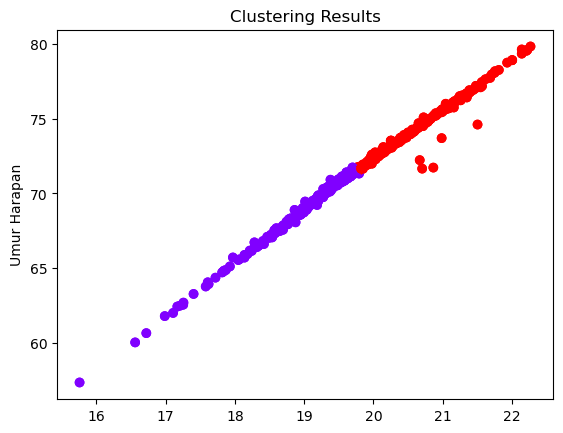

In [45]:
# VISUALISASI MENGGUNAKAN SCATTER PLOT

plt.scatter(results_pd['scaledFeat'].apply(lambda x: x[0]),
            results_pd['features'].apply(lambda x: x[1]),
            c=results_pd['prediction'],
            cmap='rainbow')
plt.title("Clustering Results")
plt.ylabel('Umur Harapan')
plt.show()